# BSSN scalar field

## This module implements a basic numerical relativity code to evolve a scalar field profile in *spherical coordinates*

### This is a spherically symmetric problem, so we can set the symmetry about the $\theta$- and $\phi$-axes. Not sampling in the $\theta$ and $\phi$  directions greatly speeds up the simulation.


### NRPy+ Source Code for this module: 
1. [BSSN_SF/ID_array_psi.py](BSSN_SF/ID_array_psi.py): Initial data to be input later; sets all ADM variables in Cartesian basis: 
1. [BSSN_SF/CartesianADMID_to_BSSNCurvilinearID.py](BSSN_SF/CartesianADMID_to_BSSNCurvilinearID.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_ADMCartesian_to_BSSNCurvilinear.ipynb): Cartesian ADM$\to$Curvilinear BSSN converter function
1. [BSSN_SF/BSSN_ID_function_string.py](BSSN_SF/BSSN_ID_function_string.py): Sets up the C code string enabling initial data be set up in a point-by-point fashion
1. [BSSN_SF/BSSN_Constraints.py](BSSN_SF/BSSNConstraints.py); [\[**tutorial**\]](Tutorial-BSSNConstraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates
1. [BSSN_SF/BSSN_RHSs.py](BSSN_SF/BSSN_RHSs.py); [\[**tutorial**\]](Tutorial-BSSNCurvilinear.ipynb): Generates the right-hand sides for the BSSN evolution equations and the evolution of the scalar field in singular, curvilinear coordinates

Here we use NRPy+ to generate the C source code necessary to set up arbitrary initial data, to be input from an array in the C code later. Then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

In [1]:
# First we import needed core NRPy+ modules
from outputC import *
import NRPy_param_funcs as par
import grid as gri
import loop as lp
import indexedexp as ixp
import finite_difference as fin
import reference_metric as rfm

# Set spatial dimension (must be 3 for BSSN)
DIM = 3
par.set_parval_from_str("grid::DIM",DIM)

# Then we set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem","Spherical")
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Then we set theta and phi to be the symmetry axes; i.e., axis "12", corresponding to the i1 and i2 directions. 
#      This sets all spatial derivatives in the phi direction to zero.
par.set_parval_from_str("indexedexp::symmetry_axes","12")

## Step 2a: First import arbitrary ADM initial data to be input from a file from the BSSN.ID_array_psi NRPy+ module

These initial data are expressed in the Cartesian coordinate basis (i.e., vectors and tensors are expressed in Cartesian components).

In [2]:
import BSSN_SF.ID_array_psi as idp
idp.ID_array_psi()


## Step 2b: Next transform the initial data ADM quantities in Cartesian coordinates to BSSN quantities in curvilinear coordinates, using the BSSN.CartesianADMID_to_BSSNCurvilinearID NRPy+ module and output result to file.

In [3]:
import BSSN_SF.CartesianADMID_to_BSSNCurvilinearID as ctob
cf,hDD,lambdaU,aDD,trK,alpha,vetU,betU = \
    ctob.Convert_Cartesian_ADM_to_BSSN_curvilinear(idp.Cartxyz, idp.gammaCartDD, 
                                                   idp.KCartDD, idp.alphaCart, idp.betaCartU, idp.BCartU)
# Now output the initial data to file:
with open("BSSN_SF/ID_array_psi.h","w") as file:
    file.write(idp.returnfunction)

## Step 3A: Output BSSN RHS expressions

In [4]:
import BSSN_SF.BSSN_RHSs as rhs
# Set the *covariant*, second-order Gamma-driving shift condition
par.set_parval_from_str("BSSN_SF.BSSN_RHSs::ShiftEvolutionOption", "GammaDriving2ndOrder_Covariant", )
rhs.BSSN_RHSs()

import time
print("Generating C code for BSSN RHSs in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
start = time.time()

BSSN_evol_rhss = [ \
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD00"),rhs=rhs.a_rhsDD[0][0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD01"),rhs=rhs.a_rhsDD[0][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD02"),rhs=rhs.a_rhsDD[0][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD11"),rhs=rhs.a_rhsDD[1][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD12"),rhs=rhs.a_rhsDD[1][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD22"),rhs=rhs.a_rhsDD[2][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","alpha"),rhs=rhs.alpha_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU0"),rhs=rhs.bet_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU1"),rhs=rhs.bet_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU2"),rhs=rhs.bet_rhsU[2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","cf"),   rhs=rhs.cf_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD00"),rhs=rhs.h_rhsDD[0][0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD01"),rhs=rhs.h_rhsDD[0][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD02"),rhs=rhs.h_rhsDD[0][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD11"),rhs=rhs.h_rhsDD[1][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD12"),rhs=rhs.h_rhsDD[1][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD22"),rhs=rhs.h_rhsDD[2][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU0"),rhs=rhs.lambda_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU1"),rhs=rhs.lambda_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU2"),rhs=rhs.lambda_rhsU[2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","trK"),  rhs=rhs.trK_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU0"),rhs=rhs.vet_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU1"),rhs=rhs.vet_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU2"),rhs=rhs.vet_rhsU[2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vv"),rhs=rhs.vv_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","uu"),rhs=rhs.uu_rhs)]

BSSN_RHSs_string = fin.FD_outputC("returnstring",BSSN_evol_rhss, params="outCverbose=False",upwindcontrolvec=rhs.betaU)
end = time.time()
print("Finished in "+str(end-start)+" seconds.")

with open("BSSN_SF/BSSN_RHSs.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx[2]","NGHOSTS+Nxx[1]","NGHOSTS+Nxx[0]"],
                       ["1","1","1"],["const REAL invdx0 = 1.0/dxx[0];\n"+
                                      "const REAL invdx1 = 1.0/dxx[1];\n"+
                                      "const REAL invdx2 = 1.0/dxx[2];\n"+
                                      "#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+BSSN_RHSs_string))

Generating C code for BSSN RHSs in Spherical coordinates.
Finished in 55.06638956069946 seconds.


## Step 3B: Output the Hamiltonian constraint

In [16]:
import BSSN_SF.BSSNConstraints as bssncon
bssncon.BSSNConstraints()

H = gri.register_gridfunctions("AUX","H")
import time
print("Generating C code for Hamiltonian constraint")
start = time.time()
Hamiltonianstring = fin.FD_outputC("returnstring",lhrh(lhs=gri.gfaccess("aux_gfs","H"),rhs=bssncon.H), 
                                   params="outCverbose=False")
end = time.time()
print("Finished in "+str(end-start)+" seconds.")

with open("BSSN_SF/Hamiltonian.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx[2]","NGHOSTS+Nxx[1]","NGHOSTS+Nxx[0]"],
                       ["1","1","1"],["const REAL invdx0 = 1.0/dxx[0];\n"+
                                      "const REAL invdx1 = 1.0/dxx[1];\n"+
                                      "const REAL invdx2 = 1.0/dxx[2];\n"+
                                      "#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+Hamiltonianstring))

Generating C code for Hamiltonian constraint
Finished in 17.95710277557373 seconds.


## Step 4: Apply singular, curvilinear coordinate boundary conditions [*a la* Section IV.E of the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)

The procedure is the same as in the [Start-to-Finish Example: Head-On Black Hole Collision](../../Unused_tutorials/Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide.ipynb):
##### Step 4A: Find locations to where outer ghost zone gridpoints map
##### Step 4B: At each ghost zone gridpoint, find and store the correct parity condition type for each gridfunction up to rank 2 (the highest rank in the BSSN RHSs)

In [17]:
# Generic coordinate NRPy+ file output, Part 1: output the coordinate bounds xxmin[] and xxmax[]:
with open("BSSN_SF/xxminmax.h", "w") as file:
    file.write("const REAL xxmin[3] = {"+str(rfm.xxmin[0])+","+str(rfm.xxmin[1])+","+str(rfm.xxmin[2])+"};\n")
    file.write("const REAL xxmax[3] = {"+str(rfm.xxmax[0])+","+str(rfm.xxmax[1])+","+str(rfm.xxmax[2])+"};\n")
# Generic coordinate NRPy+ file output, Part 2: output the conversion from (x0,x1,x2) to Cartesian (x,y,z)
outputC([rfm.xxCart[0],rfm.xxCart[1],rfm.xxCart[2]],["xCart[0]","xCart[1]","xCart[2]"],
        "BSSN_SF/xxCart.h")
# Generic coordinate NRPy+ file output, Part 3: output the conversion from Cartesian (x,y,z) to interior/OB (x0,x1,x2)
outputC([rfm.Cart_to_xx[0],rfm.Cart_to_xx[1],rfm.Cart_to_xx[2]],
        ["Cart_to_xx0_inbounds","Cart_to_xx1_inbounds","Cart_to_xx2_inbounds"],
        "BSSN_SF/Cart_to_xx.h")
# Generic coordinate NRPy+ file output, Part 4: output the proper distance between gridpoints in given coordinate system
dxx     = ixp.declarerank1("dxx",DIM=3)
ds_dirn = rfm.ds_dirn(dxx)
outputC([ds_dirn[0],ds_dirn[1],ds_dirn[2]],["ds_dirn0","ds_dirn1","ds_dirn2"],"BSSN_SF/ds_dirn.h")

Wrote to file "BSSN_SF/xxCart.h"
Wrote to file "BSSN_SF/Cart_to_xx.h"
Wrote to file "BSSN_SF/ds_dirn.h"


####   Step 4B.i: Set the parity condition for each of the 10 parity condition types

First we fill in the parity condition arrays. These take as input $(x_0,x_1,x_2)_{\rm in}$ and $(x_0,x_1,x_2)_{\rm IB}$, and output the necessary dot products for each parity type. To wit, there are 10 parity types for BSSN evolved variables, which include tensors up to and including rank-2:

0. Scalar (Rank-0 tensor)
1. Rank-1 tensor in **i0** direction
1. Rank-1 tensor in **i1** direction
1. Rank-1 tensor in **i2** direction
1. Rank-2 tensor in **i0-i0** direction
1. Rank-2 tensor in **i0-i1** direction
1. Rank-2 tensor in **i0-i2** direction
1. Rank-2 tensor in **i1-i1** direction
1. Rank-2 tensor in **i1-i2** direction
1. Rank-2 tensor in **i2-i2** direction

In [18]:
parity = ixp.zerorank1(DIM=10)
UnitVectors_inner = ixp.zerorank2()
xx0_inbounds,xx1_inbounds,xx2_inbounds = sp.symbols("xx0_inbounds xx1_inbounds xx2_inbounds", real=True)
for i in range(3):
    for j in range(3):
        UnitVectors_inner[i][j] = rfm.UnitVectors[i][j].subs(rfm.xx[0],xx0_inbounds).subs(rfm.xx[1],xx1_inbounds).subs(rfm.xx[2],xx2_inbounds)
# Type 0: scalar
parity[0] = sp.sympify(1)
# Type 1: i0-direction vector or one-form
# Type 2: i1-direction vector or one-form
# Type 3: i2-direction vector or one-form
for i in range(3):
    for Type in range(1,4):
        parity[Type] += rfm.UnitVectors[Type-1][i]*UnitVectors_inner[Type-1][i]
# Type 4: i0i0-direction rank-2 tensor
# parity[4] = parity[1]*parity[1]
# Type 5: i0i1-direction rank-2 tensor
# Type 6: i0i2-direction rank-2 tensor
# Type 7: i1i1-direction rank-2 tensor
# Type 8: i1i2-direction rank-2 tensor
# Type 9: i2i2-direction rank-2 tensor
count = 4
for i in range(3):
    for j in range(i,3):
        parity[count] = parity[i+1]*parity[j+1]
        count = count + 1

lhs_strings = []
for i in range(10):
    lhs_strings.append("parity["+str(i)+"]")
outputC(parity,lhs_strings, "BSSN_SF/set_parity_conditions.h")

Wrote to file "BSSN_SF/set_parity_conditions.h"


####   Step 4B.ii: Implement the boundary condition ghost zone mapping routine, difining the parity conditions

In [19]:
%%writefile BSSN_SF/curvilinear_parity_and_outer_boundary_conditions.h

// First we define the struct that will be used to store the 10 parity conditions at all gridpoints:
// We store the 10 parity conditions in a struct consisting of 10 integers, one for each condition.
// Note that these conditions can only take one of two values: +1 or -1.
typedef struct parity_conditions {
  int8_t parity[10];
} parity_condition;

typedef struct ghostzone_map {
  short i0,i1,i2;
} gz_map;

void set_bc_parity_conditions(REAL parity[10], const REAL xx0,const REAL xx1,const REAL xx2, 
                              const REAL xx0_inbounds,const REAL xx1_inbounds,const REAL xx2_inbounds) {
    #include "set_parity_conditions.h"
}

void set_up_bc_gz_map_and_parity_conditions(const int Nxx_plus_2NGHOSTS[3], REAL *xx[3], 
                                            const REAL dxx[3], const REAL xxmin[3], const REAL xxmax[3], 
                                            gz_map *bc_gz_map, parity_condition *bc_parity_conditions) {
  LOOP_REGION(0,Nxx_plus_2NGHOSTS[0],0,Nxx_plus_2NGHOSTS[1],0,Nxx_plus_2NGHOSTS[2]) {
    REAL xCart[3];
    xxCart(xx, i0,i1,i2, xCart);
    REAL Cartx = xCart[0];
    REAL Carty = xCart[1];
    REAL Cartz = xCart[2];
    
    REAL Cart_to_xx0_inbounds,Cart_to_xx1_inbounds,Cart_to_xx2_inbounds;
#include "Cart_to_xx.h"
    int i0_inbounds = (int)( (Cart_to_xx0_inbounds - xxmin[0] - (1.0/2.0)*dxx[0] + ((REAL)NGHOSTS)*dxx[0])/dxx[0] + 0.5 ); 
    int i1_inbounds = (int)( (Cart_to_xx1_inbounds - xxmin[1] - (1.0/2.0)*dxx[1] + ((REAL)NGHOSTS)*dxx[1])/dxx[1] + 0.5 );
    int i2_inbounds = (int)( (Cart_to_xx2_inbounds - xxmin[2] - (1.0/2.0)*dxx[2] + ((REAL)NGHOSTS)*dxx[2])/dxx[2] + 0.5 );

    REAL xCart_orig[3]; for(int ii=0;ii<3;ii++) xCart_orig[ii] = xCart[ii];
    xxCart(xx, i0_inbounds,i1_inbounds,i2_inbounds, xCart);

#define EPS_ABS 1e-8
    if(fabs( (double)(xCart_orig[0] - xCart[0]) ) > EPS_ABS ||
       fabs( (double)(xCart_orig[1] - xCart[1]) ) > EPS_ABS ||
       fabs( (double)(xCart_orig[2] - xCart[2]) ) > EPS_ABS) {
      printf("Error. Cartesian disagreement: ( %.15e %.15e %.15e ) != ( %.15e %.15e %.15e )\n",
             (double)xCart_orig[0],(double)xCart_orig[1],(double)xCart_orig[2],
             (double)xCart[0],(double)xCart[1],(double)xCart[2]);
      exit(1);
    }

    if(i0_inbounds-i0 == 0 && i1_inbounds-i1 == 0 && i2_inbounds-i2 == 0) {
      bc_gz_map[IDX3(i0,i1,i2)].i0=-1;
      bc_gz_map[IDX3(i0,i1,i2)].i1=-1;
      bc_gz_map[IDX3(i0,i1,i2)].i2=-1;
      for(int which_parity=0; which_parity<10; which_parity++) {
        bc_parity_conditions[IDX3(i0,i1,i2)].parity[which_parity] = 1;
      }
    } else {
      bc_gz_map[IDX3(i0,i1,i2)].i0=i0_inbounds;
      bc_gz_map[IDX3(i0,i1,i2)].i1=i1_inbounds;
      bc_gz_map[IDX3(i0,i1,i2)].i2=i2_inbounds;
      const REAL xx0 = xx[0][i0];
      const REAL xx1 = xx[1][i1];
      const REAL xx2 = xx[2][i2];
      const REAL xx0_inbounds = xx[0][i0_inbounds];
      const REAL xx1_inbounds = xx[1][i1_inbounds];
      const REAL xx2_inbounds = xx[2][i2_inbounds];
      REAL REAL_parity_array[10];
      set_bc_parity_conditions(REAL_parity_array,  xx0,xx1,xx2, xx0_inbounds,xx1_inbounds,xx2_inbounds);
      for(int whichparity=0;whichparity<10;whichparity++) {
          //printf("Good? Parity %d evaluated to %e\n",whichparity,REAL_parity_array[whichparity]);
          // Perform sanity check on parity array output: should be +1 or -1 to within 8 significant digits:
          if( (REAL_parity_array[whichparity]  > 0 && fabs(REAL_parity_array[whichparity] - (+1)) > 1e-8) ||
              (REAL_parity_array[whichparity] <= 0 && fabs(REAL_parity_array[whichparity] - (-1)) > 1e-8) ) {
              printf("Error. Parity evaluated to %e , which is not within 8 significant digits of +1 or -1.",REAL_parity_array[whichparity]);
              exit(1);
          }
          if(REAL_parity_array[whichparity] < 0.0) bc_parity_conditions[IDX3(i0,i1,i2)].parity[whichparity] = -1;
          if(REAL_parity_array[whichparity] > 0.0) bc_parity_conditions[IDX3(i0,i1,i2)].parity[whichparity] = +1;
      }
    }
  }
}

// Part P6: Declare boundary condition OB_UPDATE macro,
//          which updates a single face of the 3D grid cube
//          using quadratic polynomial extrapolation.
const int MAXFACE = -1;
const int NUL     = +0;
const int MINFACE = +1;


#define OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2) \
  LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) {                  \
    const int idx3 = IDX3(i0,i1,i2);                                    \
    if(bc_gz_map[idx3].i0 == -1 && inner==0) {                          \
      gfs[IDX4(which_gf,i0,i1,i2)] =                                    \
        +3.0*gfs[IDX4(which_gf,i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]    \
        -3.0*gfs[IDX4(which_gf,i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]    \
        +1.0*gfs[IDX4(which_gf,i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)];   \
    } else if(bc_gz_map[idx3].i0 != -1 && inner==1) {                   \
     gfs[IDX4(which_gf,i0,i1,i2)] =                                    \
        ( (REAL)bc_parity_conditions[idx3].parity[evol_gf_parity[which_gf]] )* \
                                             gfs[IDX4(which_gf,           \
                                                    bc_gz_map[idx3].i0, \
                                                    bc_gz_map[idx3].i1, \
                                                    bc_gz_map[idx3].i2)]; \
    }                                                                   \
  }

// Part P7: Boundary condition driver routine: Apply BCs to all six
//          boundary faces of the cube, filling in the innermost
//          ghost zone first, and moving outward.
void apply_bcs(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],
               gz_map *bc_gz_map,parity_condition *bc_parity_conditions,REAL *gfs) {
#pragma omp parallel for
  for(int which_gf=0;which_gf<NUM_EVOL_GFS;which_gf++) {
    int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
    int imax[3] = { Nxx_plus_2NGHOSTS[0]-NGHOSTS, Nxx_plus_2NGHOSTS[1]-NGHOSTS, Nxx_plus_2NGHOSTS[2]-NGHOSTS };
    for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
      for(int inner=0;inner<2;inner++) {
        // After updating each face, adjust imin[] and imax[] 
        //   to reflect the newly-updated face extents.
        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]--;
        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]++;

        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]--;
        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]++;

        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]--;
        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]++;
        if(inner==0) { for(int ii=0;ii<3;ii++) {imin[ii]++; imax[ii]--;} }
      }
    }
  }
}

Overwriting BSSN_SF/curvilinear_parity_and_outer_boundary_conditions.h


####   Step 4B.iii: Set the #define list for all gridfunctions

In [20]:
# First we set up the evolved and auxiliary variables lists
evolved_variables_list   = []
auxiliary_variables_list = []
for i in range(len(gri.glb_gridfcs_list)):
    if gri.glb_gridfcs_list[i].gftype == "EVOL":
        evolved_variables_list.append(gri.glb_gridfcs_list[i].name)
    if gri.glb_gridfcs_list[i].gftype == "AUX":
        auxiliary_variables_list.append(gri.glb_gridfcs_list[i].name)

# Next we alphabetize the lists
evolved_variables_list.sort()
auxiliary_variables_list.sort()

# Finally we set up the #define statements:
with open("BSSN_SF/gridfunction_defines.h", "w") as file:
    file.write("/* This file is automatically generated by NRPy+. Do not edit. */\n\n")
    file.write("/* EVOLVED VARIABLES: */\n")
    file.write("#define NUM_EVOL_GFS "+str(len(evolved_variables_list))+"\n")
    for i in range(len(evolved_variables_list)):
        file.write("#define "+evolved_variables_list[i].upper()+"GF\t"+str(i)+"\n")
    file.write("\n\n /* AUXILIARY VARIABLES: */\n")
    file.write("#define NUM_AUX_GFS "+str(len(auxiliary_variables_list))+"\n")
    for i in range(len(auxiliary_variables_list)):
        file.write("#define "+auxiliary_variables_list[i].upper()+"GF\t"+str(i)+"\n")

####   Step 4B.iv: Assign the correct parity condition for each BSSN gridfunction

In [21]:
# Next we set the parity conditions on all evolved gridfunctions, based on how many digits are at the end of their names
parity_type = []
for i in range(len(evolved_variables_list)):
    varname = evolved_variables_list[i]
    parity_type__orig_len = len(parity_type)
    if  len(varname)>2:
        if   varname[len(varname)-2] == "0" and varname[len(varname)-1] == "0":
            parity_type.append(4)
        elif varname[len(varname)-2] == "0" and varname[len(varname)-1] == "1":
            parity_type.append(5)
        elif varname[len(varname)-2] == "0" and varname[len(varname)-1] == "2":
            parity_type.append(6)
        elif varname[len(varname)-2] == "1" and varname[len(varname)-1] == "1":
            parity_type.append(7)
        elif varname[len(varname)-2] == "1" and varname[len(varname)-1] == "2":
            parity_type.append(8)
        elif varname[len(varname)-2] == "2" and varname[len(varname)-1] == "2":
            parity_type.append(9)
    if len(varname)>1 and len(parity_type) == parity_type__orig_len:
        if   varname[len(varname)-1] == "0":
            parity_type.append(1)
        elif varname[len(varname)-1] == "1":
            parity_type.append(2)
        elif varname[len(varname)-1] == "2":
            parity_type.append(3)
    if varname[len(varname)-1].isdigit() == False:
        parity_type.append(0)

    if len(parity_type) == parity_type__orig_len:
        print("Error: Could not figure out parity type for evolved variable: "+varname)
        exit(1)


with open("BSSN_SF/gridfunction_defines.h", "a") as file:
    file.write("\n\n/* PARITY TYPES FOR EVOLVED VARIABLES.\n")
    file.write("   SEE \"Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide.ipynb\" FOR DEFINITIONS. */\n")
    file.write("const int8_t evol_gf_parity["+str(len(evolved_variables_list))+"] = { ")
    for i in range(len(evolved_variables_list)-1):
        file.write(str(parity_type[i])+", ")
    file.write(str(parity_type[len(evolved_variables_list)-1])+" };\n")
    
for i in range(len(evolved_variables_list)):
    print("Evolved gridfunction \""+evolved_variables_list[i]+"\" has parity type "+str(parity_type[i])+".")

Evolved gridfunction "Rtrace" has parity type 0.
Evolved gridfunction "aDD00" has parity type 4.
Evolved gridfunction "aDD01" has parity type 5.
Evolved gridfunction "aDD02" has parity type 6.
Evolved gridfunction "aDD11" has parity type 7.
Evolved gridfunction "aDD12" has parity type 8.
Evolved gridfunction "aDD22" has parity type 9.
Evolved gridfunction "alpha" has parity type 0.
Evolved gridfunction "betU0" has parity type 1.
Evolved gridfunction "betU1" has parity type 2.
Evolved gridfunction "betU2" has parity type 3.
Evolved gridfunction "cf" has parity type 0.
Evolved gridfunction "hDD00" has parity type 4.
Evolved gridfunction "hDD01" has parity type 5.
Evolved gridfunction "hDD02" has parity type 6.
Evolved gridfunction "hDD11" has parity type 7.
Evolved gridfunction "hDD12" has parity type 8.
Evolved gridfunction "hDD22" has parity type 9.
Evolved gridfunction "lambdaU0" has parity type 1.
Evolved gridfunction "lambdaU1" has parity type 2.
Evolved gridfunction "lambdaU2" has 

## Step 5: Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658))

Again as in [Start-to-Finish Example: Head-On Black Hole Collision](../../Unused_tutorials/Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide.ipynb).

In [22]:
# First define the Kronecker delta:
KroneckerDeltaDD = ixp.zerorank2()
for i in range(DIM):
    KroneckerDeltaDD[i][i] = sp.sympify(1)

# The detgammabar in BSSN_RHSs is set to detgammahat when BSSN_RHSs::detgbarOverdetghat_equals_one=True (default),
#    so we manually compute it here:
dummygammabarUU, detgammabar = ixp.symm_matrix_inverter3x3(rhs.gammabarDD)

# Next apply the constraint enforcement equation above.
hprimeDD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        hprimeDD[i][j] = \
        (sp.Abs(rfm.detgammahat)/detgammabar)**(sp.Rational(1,3)) * (KroneckerDeltaDD[i][j] + rhs.hDD[i][j]) \
        - KroneckerDeltaDD[i][j]

enforce_detg_constraint_vars = [ \
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD00"),rhs=hprimeDD[0][0]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD01"),rhs=hprimeDD[0][1]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD02"),rhs=hprimeDD[0][2]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD11"),rhs=hprimeDD[1][1]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD12"),rhs=hprimeDD[1][2]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD22"),rhs=hprimeDD[2][2]) ]

enforce_gammadet_string = fin.FD_outputC("returnstring",enforce_detg_constraint_vars,
                                         params="outCverbose=False,preindent=0,includebraces=False")

with open("BSSN_SF/enforce_detgammabar_constraint.h", "w") as file:
    indent = "   "
    file.write("void enforce_detgammabar_constraint(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3], REAL *in_gfs) {\n\n")
    file.write(lp.loop(["i2","i1","i0"],["0","0","0"],
                       ["Nxx_plus_2NGHOSTS[2]","Nxx_plus_2NGHOSTS[1]","Nxx_plus_2NGHOSTS[0]"],
                       ["1","1","1"],["#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+enforce_gammadet_string))
    file.write("}\n")

# BSSNScalar_Field.c: The Main C Code

!rm BSSN_SF/BSSNScalar_Field.c
!mkdir BSSN_SF-evolution
!mkdir BSSN_SF-output2D

In [11]:
import cmdline_helper as cmd
import os

#cmd.delete_existing_files('BSSN_SF/BSSNScalar_Field.c')
cmd.mkdir('BSSN_SF-evolution')
cmd.mkdir('BSSN_SF-output2D')

In [25]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("BSSN_SF/BSSNScalar_Field.c", "w") as file:
    file.write("// Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    # Upwinding in BSSN requires that NGHOSTS = FD_CENTDERIVS_ORDER/2 + 1 <- Notice the +1.
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2)+1)+"\n")

In [26]:
%%writefile -a BSSN_SF/BSSNScalar_Field.c

// Step P1a: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"

// Step P1b: Import necessary gsl libraries for interpolating the initial data onto the grid

#include "gsl/gsl_spline.h"
#include "gsl/gsl_errno.h"
#include "gsl/gsl_interp.h"

// Step P2: Add needed #define's to set data type, the IDX4() macro, and the gridfunctions
// Step P2a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double

// Step P3: Set free parameters
// Step P3a: Free parameters for the numerical grid

// Spherical coordinates parameter
const REAL RMAX    = 256.; /* Set to approximately the time you wish to evolve for, 
                            * so that at t=t_final data at the origin is not 
                            * affected by the boundary conditions */
// Time coordinate parameters
const REAL t_final =  300.;
const REAL CFL_FACTOR = 0.5; // Set the CFL Factor

// Step P3b: Free parameters for the spacetime evolution
const REAL eta = 2.; // Gamma-driving shift condition parameter.

// Step P4: Implement the algorithm for upwinding.
//          *NOTE*: This upwinding is backwards from
//          usual upwinding algorithms, because the
//          upwinding control vector in BSSN (the shift)
//          acts like a *negative* velocity.
#define UPWIND_ALG(UpwindVecU) UpwindVecU > 0.0 ? 1.0 : 0.0

// Step P5: Set free parameters for Psi initial data
const REAL psi_posn_x = 0.0,psi_posn_y = 0.0,psi_posn_z = 0.0;

// Step P5b: Set free parameters for the scalar field
const REAL scalar_posn_x = 0.0;
const REAL scalar_posn_y = 0.0;
const REAL scalar_posn_z = 0.0;
const REAL br_on = 1.; // Turn on(1.)/off(0.) scalar field backreaction on the metric
const REAL pot1_on = 1.; // Turn on(1.)/off(0.) quadratic potential
const REAL pot2_on = 0.; // Turn on(1.)/off(0.) self-interactiong potential
// Make sure only one potential is on at a time
// Variables for the scalar field potential
const REAL scalarmass = 1.; // Scalar mass, \mu = c/\hbar m
const REAL fa = 0.05; // Decay constant, only relevant for the self-interacting potential

//Step P5c: Declare vars for initial data arrays
//          We use initial data profiles for the scalar 
//          and the conformal factor that is known to 
//          lead to stable scalar field evolution
REAL uu_in;
REAL vv_in;
REAL psi_in;
REAL alpha_in;
REAL r_scalar;
REAL r_psi;

// Step P6: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//          data in a 1D array. In this case, consecutive values of "i" 
//          (all other indices held to a fixed value) are consecutive in memory, where 
//          consecutive values of "j" (fixing all other indices) are separated by 
//          Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//          "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )

// Step P7: Set #define's for BSSN gridfunctions. C code generated above
#include "gridfunction_defines.h"

#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)

void xxCart(REAL *xx[3],const int i0,const int i1,const int i2, REAL xCart[3]) {
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
#include "xxCart.h"
}

// Step P8: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "curvilinear_parity_and_outer_boundary_conditions.h"

#include "enforce_detgammabar_constraint.h"

// Step P9: Find the CFL-constrained timestep
REAL find_timestep(const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3],REAL *xx[3], const REAL CFL_FACTOR) {
  const REAL dxx0 = dxx[0], dxx1 = dxx[1], dxx2 = dxx[2];
  REAL dsmin = 1e38; // Start with a crazy high value... close to the largest number in single precision.
  LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
    const REAL xx0 = xx[0][i0], xx1 = xx[1][i1], xx2 = xx[2][i2];
    REAL ds_dirn0, ds_dirn1, ds_dirn2;
#include "ds_dirn.h"
#define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
    // Set dsmin = MIN(dsmin, ds_dirn0, ds_dirn1, ds_dirn2);
    dsmin = MIN(dsmin,MIN(ds_dirn0,MIN(ds_dirn1,ds_dirn2)));
  }
  return dsmin*CFL_FACTOR;
}

// Contains BSSN_ID() for arbitrary initial data array
#include "ID_array_psi.h" 

// Step P10: Declare the function for the exact solution. time==0 corresponds to the initial data.
void initial_data(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3], REAL *in_gfs) {

// Step P11a: Declare initial data arrays
FILE *uu_file = fopen("BSSN_SF/InitialData/phi001.csv", "r");
FILE *vv_file = fopen("BSSN_SF/InitialData/Pi001.csv", "r");
FILE *psi_file = fopen("BSSN_SF/InitialData/psi001.csv", "r");
FILE *alpha_file = fopen("BSSN_SF/InitialData/alpha001.csv", "r");

int temp;
int alen = 0;
while(fscanf(uu_file,"%lf\n",&temp)==1){
    alen++;
}
double r_arr[alen];
double uu_in_arr[alen];
double vv_in_arr[alen];
double psi_in_arr[alen];
double alpha_in_arr[alen];
    
rewind(uu_file);
for(int i=0;i<alen;i++){
    r_arr[i] = 0.01*i;
    fscanf(uu_file, "%lf\n", &uu_in_arr[i]);
    fscanf(vv_file, "%lf\n", &vv_in_arr[i]);
    fscanf(psi_file, "%lf\n", &psi_in_arr[i]);
    fscanf(alpha_file, "%lf\n", &alpha_in_arr[i]);
}

// Step P11b: Declare splines to interpolate onto the cartesian grid
    
gsl_interp_accel *acc = gsl_interp_accel_alloc ();
    
gsl_spline *spline_u = gsl_spline_alloc (gsl_interp_cspline, alen);
gsl_spline_init(spline_u, r_arr, uu_in_arr, alen);

gsl_spline *spline_v = gsl_spline_alloc (gsl_interp_cspline, alen);
gsl_spline_init(spline_v, r_arr, vv_in_arr, alen);

gsl_spline *spline_psi = gsl_spline_alloc (gsl_interp_cspline, alen);
gsl_spline_init(spline_psi, r_arr, psi_in_arr, alen);
    
gsl_spline *spline_alpha = gsl_spline_alloc (gsl_interp_cspline, alen);
gsl_spline_init(spline_alpha, r_arr, alpha_in_arr, alen);

#pragma omp parallel for
  LOOP_REGION(0,Nxx_plus_2NGHOSTS[0], 0,Nxx_plus_2NGHOSTS[1], 0,Nxx_plus_2NGHOSTS[2]) {
    const int idx = IDX3(i0,i1,i2);
    REAL xCart[3];
    xxCart(xx, i0,i1,i2, xCart);
    {
        r_psi = sqrt(pow(-psi_posn_x + xCart[0], 2) + pow(-psi_posn_y + xCart[1], 2) + pow(-psi_posn_z + xCart[2], 2));
        psi_in = gsl_spline_eval (spline_psi, r_psi, acc);
        alpha_in = gsl_spline_eval (spline_alpha, r_psi, acc);
    }
    BSSN_ID(xx[0][i0],xx[1][i1],xx[2][i2],xCart[0],xCart[1],xCart[2],
            &in_gfs[IDX4pt(HDD00GF,idx)],&in_gfs[IDX4pt(HDD01GF,idx)],&in_gfs[IDX4pt(HDD02GF,idx)],
            &in_gfs[IDX4pt(HDD11GF,idx)],&in_gfs[IDX4pt(HDD12GF,idx)],&in_gfs[IDX4pt(HDD22GF,idx)],
            &in_gfs[IDX4pt(TRKGF,idx)],
            &in_gfs[IDX4pt(ADD00GF,idx)],&in_gfs[IDX4pt(ADD01GF,idx)],&in_gfs[IDX4pt(ADD02GF,idx)],
            &in_gfs[IDX4pt(ADD11GF,idx)],&in_gfs[IDX4pt(ADD12GF,idx)],&in_gfs[IDX4pt(ADD22GF,idx)],
            &in_gfs[IDX4pt(LAMBDAU0GF,idx)],&in_gfs[IDX4pt(LAMBDAU1GF,idx)],&in_gfs[IDX4pt(LAMBDAU2GF,idx)],
            &in_gfs[IDX4pt(VETU0GF,idx)],&in_gfs[IDX4pt(VETU1GF,idx)],&in_gfs[IDX4pt(VETU2GF,idx)],
            &in_gfs[IDX4pt(BETU0GF,idx)],&in_gfs[IDX4pt(BETU1GF,idx)],&in_gfs[IDX4pt(BETU2GF,idx)],
            &in_gfs[IDX4pt(ALPHAGF,idx)],&in_gfs[IDX4pt(CFGF,idx)]);
    REAL xx0 = xCart[0];
    REAL xx1 = xCart[1];
    REAL xx2 = xCart[2];
    {
        r_scalar = sqrt(pow(-scalar_posn_x + xx0, 2) + pow(-scalar_posn_y + xx1, 2) + pow(-scalar_posn_z + xx2, 2));
        in_gfs[IDX4(UUGF, i0, i1, i2)] = gsl_spline_eval (spline_u, r_scalar, acc);
        in_gfs[IDX4(VVGF, i0, i1, i2)] = gsl_spline_eval (spline_v, r_scalar, acc);
    }
  }
}

// Step P12: Implement Hamiltonian constraint diagnostic
void Hamiltonian_constraint(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], 
                            REAL *in_gfs, REAL *aux_gfs) {
#include "Hamiltonian.h"    
}

// Step P13: Declare the function to evaluate the BSSN RHSs
void rhs_eval(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], const REAL *in_gfs,REAL *rhs_gfs) {
#include "BSSN_RHSs.h"
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {

  // Step 0a: Read command-line input, error out if nonconformant
  if(argc != 4 || atoi(argv[1]) < NGHOSTS) {
      printf("Error: Expected one command-line argument: ./BSSNCurvilinear_Playground Nx0 Nx1 Nx2,\n");
      printf("where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
      printf("Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
      exit(1);
  }
  // Step 0b: Set up numerical grid structure, first in space...
  const int Nx0 = atoi(argv[1]);
  const int Nx1 = atoi(argv[2]);
  const int Nx2 = atoi(argv[3]);
  if(Nx0%2 != 0 || Nx1%2 != 0 || Nx2%2 != 0) {
    printf("Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
    printf("       For example, in case of angular directions, proper symmetry zones will not exist.\n");
    exit(1);
  }
  const int Nxx[3] = { Nx0, Nx1, Nx2 };
  const int Nxx_plus_2NGHOSTS[3] = { Nxx[0]+2*NGHOSTS, Nxx[1]+2*NGHOSTS, Nxx[2]+2*NGHOSTS };
  const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2];
#include "xxminmax.h"

  // Step 0c: Allocate memory for gridfunctions
  REAL *evol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *next_in_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *aux_gfs  = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k1_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k2_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k3_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k4_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);

  // Step 0d: Set up space and time coordinates
  // Step 0d.i: Set \Delta x^i on uniform grids.
  REAL dxx[3];
  for(int i=0;i<3;i++) dxx[i] = (xxmax[i] - xxmin[i]) / ((REAL)Nxx[i]);

  // Step 0d.ii: Set up uniform coordinate grids
  REAL *xx[3];
  for(int i=0;i<3;i++) {
    xx[i] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS[i]);
    for(int j=0;j<Nxx_plus_2NGHOSTS[i];j++) {
      xx[i][j] = xxmin[i] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx[i]; // Cell-centered grid.
    }
  }

  // Step 0d.iii: Set timestep based on smallest proper distance between gridpoints and CFL factor 
  REAL dt = find_timestep(Nxx_plus_2NGHOSTS, dxx,xx, CFL_FACTOR);
  //printf("# Timestep set to = %e\n",(double)dt);
  int N_final = (int)(t_final / dt + 0.5); // The number of iterations in time.
                                           //Add 0.5 to account for C rounding down integers.

  // Step 0e: Find ghostzone mappings and parities:
  gz_map *bc_gz_map = (gz_map *)malloc(sizeof(gz_map)*Nxx_plus_2NGHOSTS_tot);
  parity_condition *bc_parity_conditions = (parity_condition *)malloc(sizeof(parity_condition)*Nxx_plus_2NGHOSTS_tot);
  set_up_bc_gz_map_and_parity_conditions(Nxx_plus_2NGHOSTS,xx,dxx,xxmin,xxmax,  bc_gz_map, bc_parity_conditions);

  // Step 1: Set up initial data to be exact solution at time=0:
  initial_data(Nxx_plus_2NGHOSTS, xx, evol_gfs);

  // Step 1b: Apply boundary conditions *FOR VALIDATION PURPOSES*
  apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions, evol_gfs);
  enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);

  // Step 2: Evaluate Hamiltonian constraint violation
  Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);

  // Step 3: Start the timer, for keeping track of how fast the simulation is progressing.
  //struct timespec start, end;
  //clock_gettime(CLOCK_REALTIME, &start);

  // Step 4: Integrate the initial data forward in time using the Method of Lines and RK4

  char filename2[100];
  sprintf(filename2,"BSSN_SF-evolution/quad_pot_uu_vv_cf.txt");
  FILE *evol = fopen(filename2, "w");
  for(int n=0;n<=N_final;n++) { // Main loop to progress forward in time.
    /***************************************************/
    /* Implement RK4 for Method of Lines timestepping: */
    /***************************************************/
    /* -= RK4: Step 1 of 4 =- */
    /* First evaluate k1 = RHSs expression             */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,evol_gfs, k1_gfs);
    /* Next k1 -> k1*dt, and then set the input for    */
    /*    the next RHS eval call to y_n+k1/2           */
#pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
      k1_gfs[i] *= dt;
      next_in_gfs[i] = evol_gfs[i] + k1_gfs[i]*0.5;
    }
    /* Finally, apply boundary conditions to           */
    /* next_in_gfs, so its data are set everywhere.    */
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions, next_in_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);
    
    /* -= RK4: Step 2 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k2_gfs);
#pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
      k2_gfs[i] *= dt;
      next_in_gfs[i] = evol_gfs[i] + k2_gfs[i]*0.5;
    }
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions, next_in_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);

    /* -= RK4: Step 3 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k3_gfs);
#pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
      k3_gfs[i] *= dt;
      next_in_gfs[i] = evol_gfs[i] + k3_gfs[i];
    }
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions, next_in_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);

    /* -= RK4: Step 4 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k4_gfs);
#pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
      k4_gfs[i] *= dt;
      evol_gfs[i] += (1.0/6.0)*(k1_gfs[i] + 2.0*k2_gfs[i] + 2.0*k3_gfs[i] + k4_gfs[i]);
    }
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions, evol_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);
    /* Output the solution of the scalar field and the conformal factor at diffrent time slices on a 2D grid */
    if(n%50 == 0) {
        char filename[100];
        sprintf(filename,"BSSN_SF-output2D/quad_pot_2d_t-%08d.txt",n);
        FILE *out2D = fopen(filename, "w");
        const int i0MIN=NGHOSTS; // In spherical, r=Delta r/2.
        const int i1mid=Nxx_plus_2NGHOSTS[1]/2;
        const int i2mid=Nxx_plus_2NGHOSTS[2]/2;
        LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
           REAL xx0 = xx[0][i0];
           REAL xx1 = xx[1][i1];
           REAL xx2 = xx[2][i2];
           REAL xCart[3];
#include "xxCart.h"
           int idx = IDX3(i0,i1,i2);
           fprintf(out2D,"%e %e %e %e\n",xCart[1],xCart[2], evol_gfs[IDX4pt(UUGF,idx)],evol_gfs[IDX4pt(CFGF,idx)]);
         }
         fclose(out2D);
    }
       
    // Output time evolution at r=0
    int idx0 = IDX3(0,0,0);
    fprintf(evol,"%e %e %e %e\n", n*dt, evol_gfs[IDX4pt(UUGF,idx0)],evol_gfs[IDX4pt(VVGF,idx0)],evol_gfs[IDX4pt(CFGF,idx0)]);
        
    // Progress indicator printing to stdout
    // Measure average time per iteration
    //clock_gettime(CLOCK_REALTIME, &end);
    //const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
    //const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)n) / 1.0e9;

    //const int iterations_remaining = N_final - n;
    //const REAL time_remaining_in_mins = s_per_iteration_avg * (REAL)iterations_remaining / 60.0;

    //const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)n; // 4 RHS evals per gridpoint for RK4
    //const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

    // Progress indicator printing to stdout
    //printf("%c[2K", 27); // Clear the line
    //printf("It: %d t=%.2f | %.1f%%; ETA %.0f s | t/h %.2f | gp/s %.2e\r",  // \r is carriage return, move cursor to the beginning of the line
    //       n, n * (double)dt, (double)(100.0 * (REAL)n / (REAL)N_final),
    //       (double)time_remaining_in_mins*60, (double)(dt * 3600.0 / s_per_iteration_avg), (double)RHS_pt_evals_per_sec);
    //fflush(stdout); // Flush the stdout buffer
  } // End main loop to progress forward in time.
  printf("\n"); // Clear the line.
  fclose(evol);
                               
  /* Step 4: Free all allocated memory */
  free(bc_parity_conditions);
  free(bc_gz_map);
  free(k4_gfs);
  free(k3_gfs);
  free(k2_gfs);
  free(k1_gfs);
  free(aux_gfs);
  free(next_in_gfs);
  free(evol_gfs);
  for(int i=0;i<3;i++) free(xx[i]);
  return 0;
}

Appending to BSSN_SF/BSSNScalar_Field.c


!cd BSSN_SF/
import time
print("Now compiling, should take ~5 seconds...\n")
start = time.time()
#!gcc -Ofast -march=native -ftree-parallelize-loops=2 -fopenmp BSSN/BSSNCurvilinear_Playground.c -o BSSNCurvilinear_Playground -lm
#!gcc-8 -Ofast -march=native BSSN_SF/BSSNScalar_Field.c -o BSSN-SField -L/usr/local/lib -lgsl -lgslcblas -lm
cmd.C_compile("BSSN_SF/BSSNScalar_Field.c", "BSSN-SField")
end = time.time()
print("Finished in "+str(end-start)+" seconds. Running should take take ~40 seconds...\n")

start = time.time()
#!./BSSN-SField 512 2 2
cmd.Execute("BSSN-SField", "512 2 2")
end = time.time()
print("Finished in "+str(end-start)+" seconds.")

## Plot the scalar field time evolution

In [72]:
import numpy as np
from scipy.interpolate import griddata 
from pylab import savefig 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
from IPython.display import Image 
from IPython.display import HTML 
import matplotlib.image as mgimg 
import glob 
import sys 
from matplotlib import animation
plt.rcParams.update(plt.rcParamsDefault) 
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rcParams.update({'font.size': 16}) 
plt.rcParams.update({'font.family' : 'sans-serif'}) 
plt.rcParams.update({'font.sans-serif' : 'Helvetica'}) 
plt.rcParams.update({'figure.figsize' : '8., 2.9'}) 
plt.rcParams.update({'figure.autolayout': True})
evol = np.loadtxt("BSSN_SF-evolution/zero_pot_uu_vv_cf_BH_zeroinit.txt") 
t = evol[:,0] 
uu = evol[:,1] 
vv = evol[:,2] 
cf = evol[:,3]
plt.plot(t,cf, color=cm.BuGn(8/10.,1))
plt.xlabel("time") 
#plt.xticks([])
plt.ylabel(r"$\varphi(r=0)$")
#plt.ylabel(r"$e^{-4\phi}(r=0)$")
#plt.ylim(0.9,0.95)
#plt.ylim(-0.3,0.3)
plt.ylim(-1,1)
plt.xlim(-0.1,300) 
plt.savefig("BSSN_SF-evolution/zero_pot_uu_BH_zeroinit.png") 
plt.close() 

Zero Potential with Gauss initial


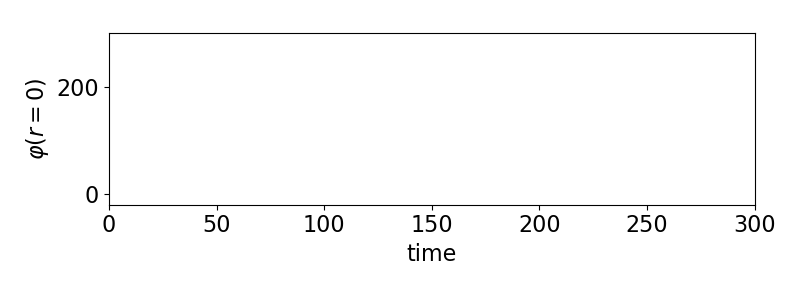

In [30]:
print("Zero Potential with Gauss initial")
Image("BSSN_SF-evolution/zero_pot_uu_Gauss.png")

Zero Potential with zero initial


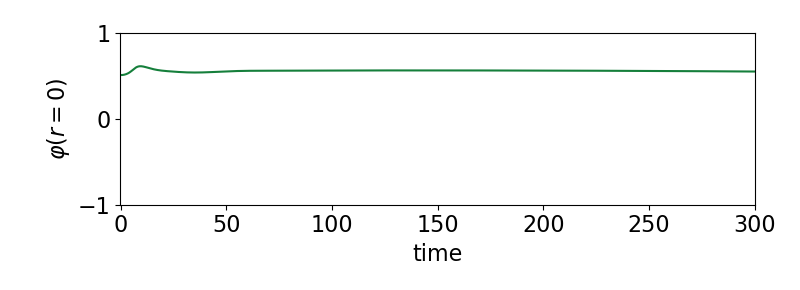

In [73]:
print("Zero Potential with zero initial")
Image("BSSN_SF-evolution/zero_pot_uu_BH_zeroinit.png")

Zero Potential


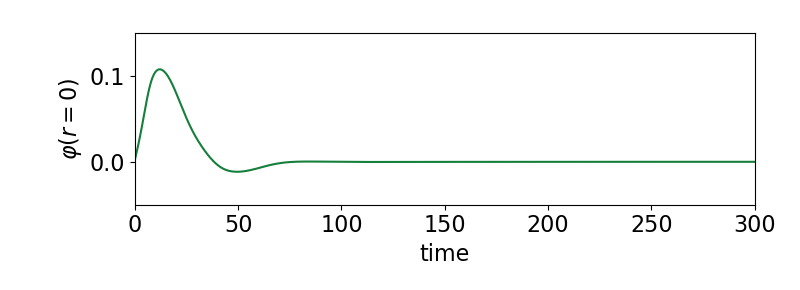

In [60]:
print("Zero Potential")
Image("BSSN_SF-evolution/zero_pot_uu_BH.png")

Quad Potential


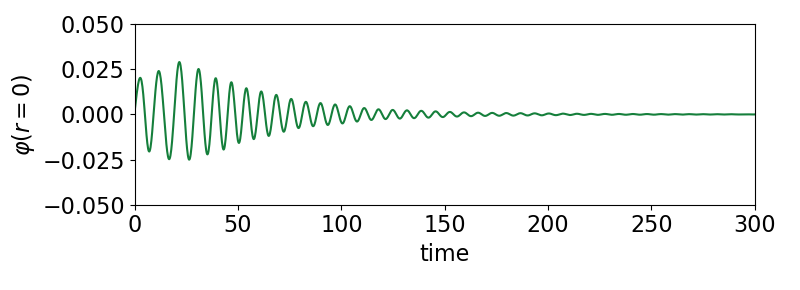

In [47]:
print("Quad Potential")
Image("BSSN_SF-evolution/quad_pot_uu_BH.png")

Self Interacting Potential


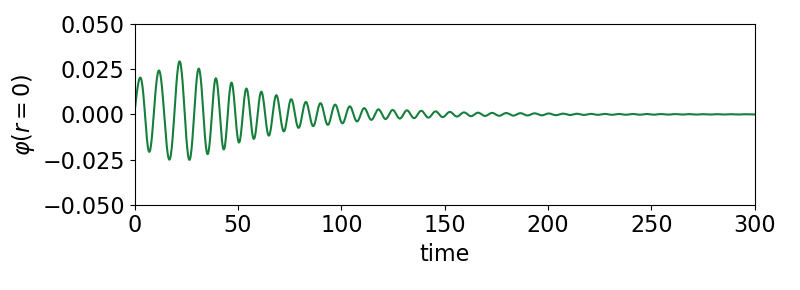

In [37]:
print("Self Interacting Potential")
Image("BSSN_SF-evolution/self_pot_uu_BH.png")

## Generate images of the scalar field on 2D grid for animation 

In [61]:
## VISUALIZATION ANIMATION, PART 1: Generate PNGs, one per frame of movie ##
import numpy as np
from scipy.interpolate import griddata
from pylab import savefig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image
from IPython.display import HTML
import matplotlib.image as mgimg
import glob
import sys
from matplotlib import animation

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.family'       : 'sans-serif'})
plt.rcParams.update({'font.sans-serif'   : 'Helvetica'})
plt.rcParams.update({'figure.figsize'    :  '5, 3.5'})
plt.rcParams.update({'figure.autolayout': True})

globby = glob.glob('BSSN_SF-output2D/zero_pot_2d_t-*_BH.txt')
file_list = []
for x in sorted(globby):
    file_list.append(x)

bound = 10.
pl_xmin = -bound
pl_xmax = +bound
pl_ymin = -bound
pl_ymax = +bound

N_interp_pts  = 300
N_interp_ptsj = 300j
j = 0
maxtime = 300
numf = len(file_list)
for filename in file_list:
    j = j + 1
    time = j*maxtime/numf
    fig = plt.figure()
    x,y,sf,cf = np.loadtxt(filename).T #Transposed for easier unpacking
    
    plotquantity = sf
    plotdescription = "Scalar field"
    plt.title("time = %.2f"%time)
    plt.xlabel("y/M")
    plt.ylabel("z/M")

    grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:N_interp_ptsj, pl_ymin:pl_ymax:N_interp_ptsj]
    points = np.zeros((len(x), 2))
    for i in range(len(x)):
        points[i][0] = x[i]
        points[i][1] = y[i]   
    
    grid = griddata(points, plotquantity, (grid_x, grid_y), method='nearest')
    gridcub = griddata(points, plotquantity, (grid_x, grid_y), method='cubic')
    im = plt.imshow(gridcub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax),cmap='YlGn')
    ax = plt.colorbar()
    ax.set_label(plotdescription)
    savefig(filename+"_sf.png",dpi=450)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file %.2f "%time+filename+"\r")
    sys.stdout.flush()

## And for the conformal factor

In [62]:
for filename in file_list:
    j = j + 1
    time = j*maxtime/numf
    fig = plt.figure()
    x,y,sf,cf = np.loadtxt(filename).T #Transposed for easier unpacking
    
    plotquantity = cf
    plotdescription = "Conformal factor"
    plt.title("time = %.2f"%time)
    plt.xlabel("y/M")
    plt.ylabel("z/M")

    grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:N_interp_ptsj, pl_ymin:pl_ymax:N_interp_ptsj]
    points = np.zeros((len(x), 2))
    for i in range(len(x)):
        # Zach says: No idea why x and y get flipped...
        points[i][0] = x[i]
        points[i][1] = y[i]   
    
    grid = griddata(points, plotquantity, (grid_x, grid_y), method='nearest')
    gridcub = griddata(points, plotquantity, (grid_x, grid_y), method='cubic')
    #im = plt.imshow(grid, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
    im = plt.imshow(gridcub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax),cmap='YlGn')
    #plt.pcolormesh(grid_y,grid_x, grid, vmin=-8, vmax=0) # Set colorbar range from -8 to 0
    ax = plt.colorbar(format='%.3f')
    ax.set_label(plotdescription)
    savefig(filename+"_cf.png",dpi=450)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file %.2f "%time+filename+"\r")
    sys.stdout.flush()

## Generate animation of the time evolution of the scalar field and the conformal factor

In [63]:
import numpy as np
from scipy.interpolate import griddata
from pylab import savefig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image
from IPython.display import HTML
import matplotlib.image as mgimg
import glob
import sys
from matplotlib import animation

globby = glob.glob('BSSN_SF-output2D/zero_pot_2d_t-*_BH.txt')
file_list = []
for x in sorted(globby):
    file_list.append(x)
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##

# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation
# Set up formatting for the movie files
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#import numpy as np
#from scipy.interpolate import griddata
#from pylab import savefig

#Writer = animation.writers['pillow']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
#Writer = animation.writers['ffmpeg']
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []
for i in range(len(file_list)):
    img = mgimg.imread(file_list[i]+"_sf.png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save("BSSN_SF_zero_pot_sf_BH.mp4",dpi=450, fps=5)#,writer='ffmpeg')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [64]:
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)-1):
    img = mgimg.imread(file_list[i]+"_cf.png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save('BSSN_SF_zero_pot_cf_BH.mp4',dpi=450, fps=5,writer='ffmpeg')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


In [44]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_self_pot_sf_BH.mp4" type="video/mp4"> 
    </video>
""")

In [43]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_self_pot_cf_BH.mp4" type="video/mp4"> 
    </video>
""")

In [52]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_quad_pot_sf_BH.mp4" type="video/mp4"> 
    </video>
""")

In [54]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_quad_pot_cf_BH.mp4" type="video/mp4"> 
    </video>
""")

In [65]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_zero_pot_sf_BH.mp4" type="video/mp4"> 
    </video>
""")

In [66]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_zero_pot_cf_BH.mp4" type="video/mp4"> 
    </video>
""")

## 1D Conformal Factor

In [49]:
## VISUALIZATION ANIMATION, PART 1: Generate PNGs, one per frame of movie ##
import numpy as np
from scipy.interpolate import griddata
from pylab import savefig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image
from IPython.display import HTML
import matplotlib.image as mgimg
import glob
import sys
from matplotlib import animation

plt.rcParams.update(plt.rcParamsDefault) 
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rcParams.update({'font.size': 16}) 
plt.rcParams.update({'font.family' : 'sans-serif'}) 
plt.rcParams.update({'font.sans-serif' : 'Helvetica'}) 
plt.rcParams.update({'figure.figsize' : '10., 4.'}) 
plt.rcParams.update({'figure.autolayout': True})

globby = glob.glob('BSSN_SF-output2D/zero_pot_2d_t-*_BH_Ham.txt')
file_list = []
for x in sorted(globby):
    file_list.append(x)

j = 0
maxtime = 300
numf = len(file_list)
for filename in file_list:
    j = j + 1
    time = j*maxtime/numf
    fig = plt.figure()
    x,y,sf,cf,ham = np.loadtxt(filename).T #Transposed for easier unpacking
    
    realx = []
    realcf = []

    for i in range(len(x)):
        if x[i] not in realx:
            realx.append(x[i])
            realcf.append(cf[i])
    
    plotdescription = "Scalar field"
    plt.title("time = %.2f"%time)
    plt.xlabel("y/M")
    plt.ylabel("Hamiltonian constraint")

    plt.plot(realx,realham, color=cm.BuGn(8/10.,1))
    plt.ylim(-0.25,1.05)
    plt.xlim(-0.1,10) 
    plt.savefig(filename + ".png") 
    plt.close() 
    
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file %.2f "%time+filename+"\r")
    sys.stdout.flush()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [50]:
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)-1):
    img = mgimg.imread(file_list[i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save('BSSN_SF_zero_pot_Ham_BH.mp4',dpi=450, fps=5,writer='ffmpeg')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


In [19]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_zero_pot_cf2D_BH.mp4" type="video/mp4"> 
    </video>
""")

In [22]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_quad_pot_cf2D_BH.mp4" type="video/mp4"> 
    </video>
""")

In [25]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_self_pot_cf2D_BH.mp4" type="video/mp4"> 
    </video>
""")

In [51]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_zero_pot_Ham_BH.mp4" type="video/mp4"> 
    </video>
""")

In [40]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_quad_pot_Ham_BH.mp4" type="video/mp4"> 
    </video>
""")

In [48]:
from IPython.display import HTML
#the filename needed to be changed manually

HTML("""
    <video width="480" height="360" controls>
        <source src="BSSN_SF_self_pot_Ham_BH.mp4" type="video/mp4"> 
    </video>
""")